In [230]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.model_selection import train_test_split


# Dataframe viewing Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

## Read in and do Further Cleaning

In [234]:
# Let's get some data
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')

In [235]:
test[test.isnull().any(axis=1)]

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,TotalFloorSF,TotalPorchSF,TotalBathrooms,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2


In [ ]:
# Impute 0 to all missing values in test
test.fillna(0,inplace=True)

In [214]:
1116+1460

2576

In [229]:
test.fillna(0, inplace=True)

## Generalized Cross Validation

Provides a convenient approximation to leave one out CV for linear fitting under a squared error loss. S is the hat matrix

$$GCV(\hat{f}) = \frac{1}{N}\sum_{i=1} \left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$$

In smoothing problems, GCV can also alleviate tendency of cross validation to undersmooth. Has similarity to AIC from the approximation 

$$1/(1-x)^2 \approx 1+2x$$

GCV is used for smoothness selection in the mgcv package in R. Smoothing parameters are chosen to minimize prediction error. GCV is preferred over CV since there's no need to refit the model onto subsets of the data. It functions like the AIC, in that smaller values indicate better fitting models. 

GAMs fitted using GCV smoothness selection can suffer from under-smoothing. 


In [106]:
# How is our data shaping up?
print('Our training dataset has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))
print('Our test dataset has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

Our training dataset has 1456 rows and 94 columns.
Our test dataset has 1459 rows and 93 columns.


In [107]:
y = train['SalePrice']
x = train.drop(columns=['Unnamed: 0', 'Id','SalePrice'], inplace=True)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2)

In [109]:
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotalPorchSF,TotalBathrooms,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2
679,120,RL,50.0,8012,2,0.0,1,4,4,Inside,...,0,2.0,1,1,0,0,0,0,1,1
1184,20,RL,89.0,12461,2,0.0,1,4,4,Corner,...,306,3.0,1,1,1,0,1,0,1,1
202,50,RL,50.0,7000,2,0.0,1,4,4,Corner,...,126,2.0,1,1,1,0,1,0,1,0
881,75,RL,60.0,6204,2,0.0,1,3,4,Inside,...,188,2.0,1,1,1,0,1,0,1,0
709,50,C (all),66.0,8712,2,2.0,1,2,4,Inside,...,98,1.0,1,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,120,RM,70.0,4438,2,0.0,1,4,4,Inside,...,0,2.0,1,1,0,0,0,1,1,1
1318,60,RL,107.0,10186,2,0.0,2,4,4,Inside,...,39,3.5,1,1,1,0,0,0,1,1
1193,60,RL,58.0,14054,2,0.0,2,4,4,Inside,...,17,2.5,1,1,1,0,0,1,0,1
62,120,RL,44.0,6442,2,0.0,2,4,4,Inside,...,49,2.0,1,1,1,0,0,1,1,1


In [110]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

In [122]:
y_train

679     143000
1184    262000
202     112000
881     118500
709     102776
         ...  
809     144500
1318    190000
1193    219210
62      202500
1042    278000
Name: SalePrice, Length: 1164, dtype: int64

In [184]:
X.dtypes

GrLivArea        int64
TotalBsmtSF      int64
OverallQual      int64
YearBuilt        int64
Fireplaces       int64
TotalPorchSF     int64
MSSubClass       int64
OverallCond      int64
Neighborhood    object
dtype: object

In [191]:

from pygam import PoissonGAM, s, te
from pygam.datasets import chicago

X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

array([[-2.55650000e+03,  3.15000000e+01, -7.43354430e+00,
        -1.95923379e+01],
       [-2.55450000e+03,  3.30000000e+01, -8.26530612e-01,
        -2.02173379e+01],
       [-2.55350000e+03,  2.90000000e+01,  5.56645570e+00,
        -1.96756712e+01],
       ...,
       [ 2.55450000e+03,  2.10000000e+01, -3.12394366e+00,
        -6.03620096e+00],
       [ 2.55550000e+03,  2.70000000e+01, -2.61239437e+01,
        -5.98700964e-01],
       [ 2.55650000e+03,  1.60000000e+01, -2.51239437e+01,
        -4.89036763e+00]])

In [201]:
from pygam import LinearGAM, s, f, te
X = X_train[['GrLivArea','TotalBsmtSF','OverallQual','YearBuilt','Fireplaces',
             'TotalPorchSF','MSSubClass','OverallCond']].to_numpy()
X_t = X_test[['GrLivArea','TotalBsmtSF','OverallQual','YearBuilt','Fireplaces',
              'TotalPorchSF','MSSubClass','OverallCond']].to_numpy()
y = np.log(y_train)
y_t = np.log(y_test)



lams = np.random.rand(30, 4) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

gam = LinearGAM(s(0)+s(1)+te(2,7)).fit(X, y)
gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (30 of 30) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     30.1557
Link Function:                     IdentityLink Log Likelihood:                                -18276.1851
Number of Samples:                         1164 AIC:                                            36614.6815
                                                AICc:                                           36616.4518
                                                GCV:                                                0.0277
                                                Scale:                                              0.0264
                                                Pseudo R-Squared:                                   0.8342
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



In [202]:
print('Average Difference in Predicted Price: ${}'.format(round(np.sqrt(np.square(np.exp(gam.predict(X_t)) - y_test).mean()),2)))

Average Difference in Predicted Price: $25606.43


In [203]:
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams['figure.figsize'] = (6, 4)

IndexError: tuple index out of range

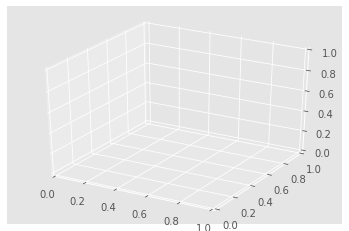

In [204]:
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

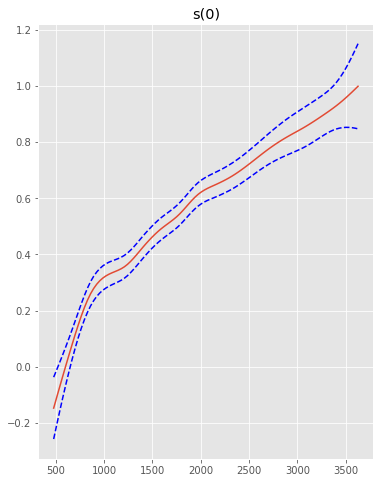

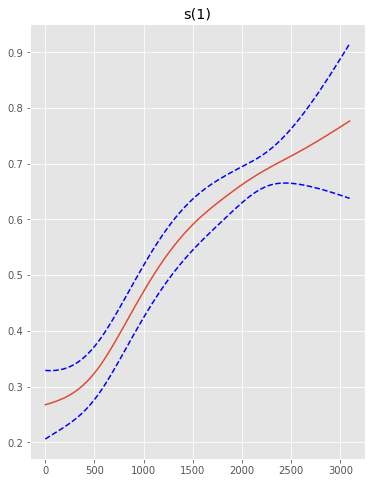

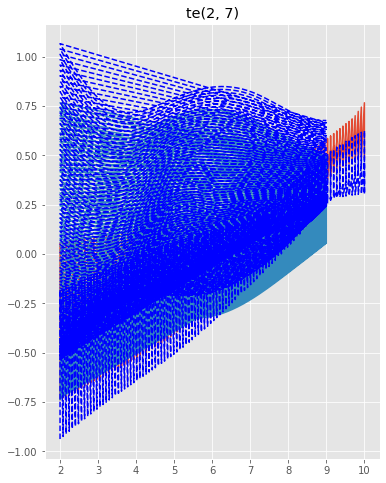

In [207]:
#names = X.columns
plt.rcParams['figure.figsize'] = (6, 8)
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='b', ls='--')
    plt.title(repr(term))
    plt.show()

In [36]:
import numpy as np

lam = np.logspace(-3,5,5)
lams = [lam] * 3

gam.gridsearch(X,y, lam=lams)
gam.summary()

100% (125 of 125) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.2948
Link Function:                     IdentityLink Log Likelihood:                                -24119.7277
Number of Samples:                         3000 AIC:                                            48260.0451
                                                AICc:                                           48260.1229
                                                GCV:                                              1244.089
                                                Scale:                                           1237.1528
                                                Pseudo R-Squared:                                   0.2915
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  import sys


In [43]:
lams = np.random.rand(100,3)
lams = lams*8-3
lams = np.exp(lams)

In [44]:
random_gam = LinearGAM(s(0) + s(1) + f(2)).gridsearch(X,y,lam=lams)
random_gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      15.968
Link Function:                     IdentityLink Log Likelihood:                                -24115.9371
Number of Samples:                         3000 AIC:                                            48265.8102
                                                AICc:                                           48266.0147
                                                GCV:                                             1247.5379
                                                Scale:                                           1235.5911
                                                Pseudo R-Squared:                                    0.294
Feature Function                  Lam

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


In [57]:
from pygam import ExpectileGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


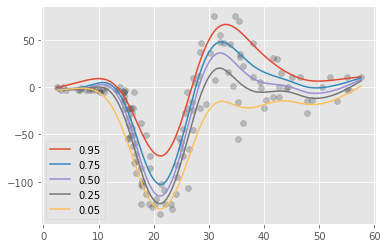

In [58]:

XX = gam50.generate_X_grid(term=0, n=500)

plt.scatter(X, y, c='k', alpha=0.2)
plt.plot(XX, gam95.predict(XX), label='0.95')
plt.plot(XX, gam75.predict(XX), label='0.75')
plt.plot(XX, gam50.predict(XX), label='0.50')
plt.plot(XX, gam25.predict(XX), label='0.25')
plt.plot(XX, gam05.predict(XX), label='0.05')
plt.legend()

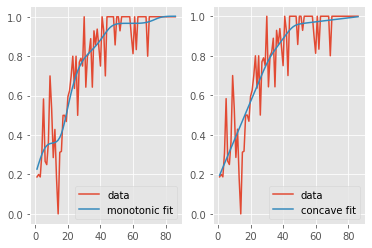

In [59]:

from pygam import LinearGAM, s
from pygam.datasets import hepatitis

X, y = hepatitis(return_X_y=True)

gam1 = LinearGAM(s(0, constraints='monotonic_inc')).fit(X, y)
gam2 = LinearGAM(s(0, constraints='concave')).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label='data')
ax[0].plot(X, gam1.predict(X), label='monotonic fit')
ax[0].legend()

ax[1].plot(X, y, label='data')
ax[1].plot(X, gam2.predict(X), label='concave fit')
ax[1].legend()

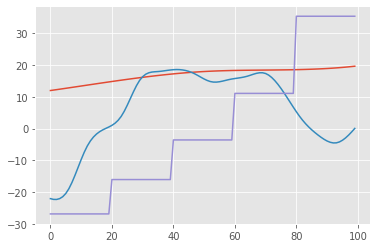

In [60]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

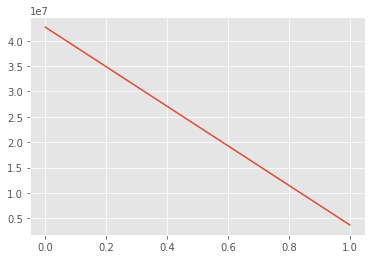

In [61]:
_ = plt.plot(gam.logs_['deviance'])

In [63]:
gam.logs_

defaultdict(list,
            {'deviance': [42655173.985630125, 3682715.8754406422],
             'diffs': [0.999999999752943, 0.0]})

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


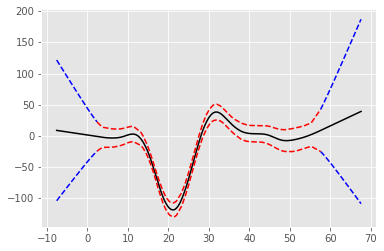

In [64]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle()

gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), 'k')
plt.plot(Xl, gam.confidence_intervals(Xl), color='b', ls='--')
plt.plot(Xr, gam.confidence_intervals(Xr), color='b', ls='--')
_ = plt.plot(X, gam.confidence_intervals(X), color='r', ls='--')

In [8]:
x_spline = df_autos[['weight', 'hp']]
bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])
bs

In [9]:
alpha = np.array([21833888.8, 6460.38479])

In [10]:
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', 
                             data=df_autos,
                             smoother=bs, 
                             alpha=alpha)

In [11]:
res_bs = gam_bs.fit()

In [12]:
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   189.13
Model Family:                Gaussian   Df Model:                        12.87
Link Function:               identity   Scale:                          4.8825
Method:                         PIRLS   Log-Likelihood:                -441.81
Date:                Wed, 27 May 2020   Deviance:                       923.45
Time:                        15:21:56   Pearson chi2:                     923.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.9923      1.997     26.034   

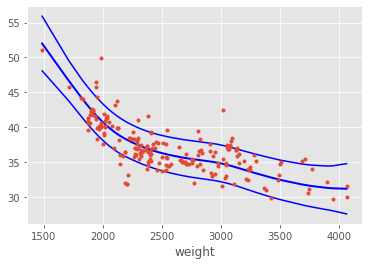

In [16]:
res_bs.plot_partial(0, cpr=True);

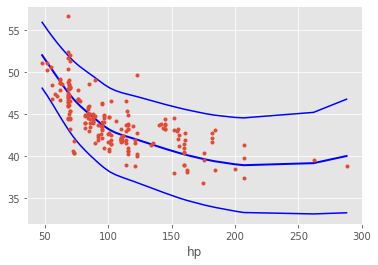

In [19]:
res_bs.plot_partial(1, cpr=True);

In [20]:
alpha = np.array([8283989284.5829611, 14628207.58927821])

In [21]:
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos,
                            smoother=bs, alpha=alpha, family=sm.families.Poisson())

In [22]:
res_bs = gam_bs.fit()

In [23]:
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   194.75
Model Family:                 Poisson   Df Model:                         7.25
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -530.38
Date:                Wed, 27 May 2020   Deviance:                       37.569
Time:                        15:27:18   Pearson chi2:                     37.4
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9960      0.130     30.844   

In [26]:
gam_bs.select_penweight_kfold()

((1995262.3149688789, 1.0),
 <statsmodels.gam.gam_cross_validation.gam_cross_validation.MultivariateGAMCVPath at 0x1a1f8f2550>)

In [25]:
gam_bs.select_penweight()[0]

array([8.28404773e+09, 1.46283641e+07])